### What is exactly an ARIMA model?
in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive(AR) moving average(MA)model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting).

(MA) use the past errors and (AR) use the past datas to forecasting, and together with each other they make ARMA and when we make the integrated version using differencing, it will be ARIMA.

so, depends on choosing the best order of p(nubmer of past datas in (AR)), d(number of differencing) and q(numbmer of past errors in (MA)) as an input in ARIMA model, we can get a proper forecasting.

#### what is ACF plot:
The ACF (autocorrelation function) is the correlation of the time series with its lags. It measures the linear relationship between lagged values of the time series. For example, we can measure the autocorrelation of yt and yt-k for different values of k.

#### what is PACF plot:
The PACF (partial autocorrelation function) shows the partial correlation of the time series with its lags, after removing the effects of lower-order-lags between them. For example, the partial autocorrelation of yt and yt-k is the correlation that is not explained by their relationships with the lags yt-1
yt-2, …, yt-k+1. It measures the balance amount of variance in yt-k to predict the future value of yt.
This is because the PACF measures the balance variance of the lags; it helps tell us whether we should include such lag within the auto-regressive (AR) models. While the ACF measures the correlations with the lags, it helps judge the moving average (MA) models. Most of the time, we should focus on either the AR or the MA models, not mixed.

#### why is stationary needed:

A stationary time series is one whose properties do not depend on the time at which the series is observed. so our input data must be stationary.
why is it so important? in order to integrate the autoregressive(AR) and moving average(MA) in ARMA and make an ARIMA, we must take differencing which is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model.
one approach is to use p_value(the probability that the results from your sample data occurred by chance).

#### our procedure:
first i get the right ARIMA_order using p_value check(for d), ACF(for q) and PACF(for p) and model a forecasting, then put my random order to ARIMA to show which one is more accurate to proof why is it so important to use the best fit for (p,d,q).



# importing the needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


# Reading the dataset

In [2]:
df = pd.read_csv('ARIMA-dataset.csv')

### show what we have

In [3]:
df.head()

,time,lat,lon,dev_acc_d
0,2022-03-19 15:12:54,35.724380,51.386521,0.00000
1,2022-03-19 15:12:59,35.723492,51.385984,0.00000
2,2022-03-19 15:13:04,35.723234,51.386712,0.07172
3,2022-03-19 15:13:09,35.723138,51.387657,0.15773
4,2022-03-19 15:13:14,35.723082,51.388778,0.25916


# Preprocessing

## null values:

##### DF info by calling the info() func, inorder to ditect null values.  As you can see, there is some null V in column: "dev_acc_d" because we have 47091 entries but "dev_acc_d" has less than our Total entries.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47091 entries, 0 to 47090
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       47091 non-null  object 
 1   lat        47091 non-null  float64
 2   lon        47091 non-null  float64
 3   dev_acc_d  45527 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.4+ MB


##### Removing the null values by Drobing the relevant Rows, then checked the df again.   now we ain't have null values.

In [5]:
#removing the entire row of null datas
df=df.dropna(subset = ["dev_acc_d"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45527 entries, 0 to 47090
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       45527 non-null  object 
 1   lat        45527 non-null  float64
 2   lon        45527 non-null  float64
 3   dev_acc_d  45527 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


## Outlier detection:

##### using  box whisker by "seaborn" to know whether our df has any outlier data or not. As you can see there is no outlier.

,lat,lon,dev_acc_d
count,45527.000000,45527.000000,45527.000000
mean,31.513659,55.703697,1218.533347
std,3.761613,4.107918,1092.691904
min,25.350712,50.849392,0.000000
25%,28.974553,51.422008,34.809530
50%,31.112903,54.991661,1167.767620
75%,35.718966,60.395760,2080.198240
max,35.724789,61.498372,3428.657320


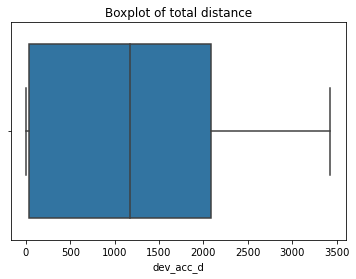

In [6]:
sns.boxplot(data=df,x=df["dev_acc_d"])
plt.title("Boxplot of total distance")
df.describe()

## Preparing the columns and data that are really needed to put in acf/pacf and ARIMA

In [7]:
#removing the 'lat' and 'lon' columns. no need for them because we just need the total distance in each day
df = df.drop(columns =['lat' , 'lon'])

In [8]:
#seprating the 'date' from the 'time' in first column by split func, then put the distinct values in 'new_date'
#get the last value of column 'dev_acc_d' for each 'date' and put it in 'new_dist'.
new_date = []
new_dist = []
new_date.append(df[df.columns[0]][0].split(" ")[0])
new_dist.append(df[df.columns[-1]][0])
counter = 0
for index, row in df.iterrows():
    if new_date[counter] != row[df.columns[0]].split(" ")[0]:
        new_date.append(row[df.columns[0]].split(" ")[0])
        new_dist.append(row[df.columns[-1]])
        counter += 1
    new_dist[counter] = row[df.columns[-1]]

#getting the difference of distance from the last day and the day before and then overright it to new_dist.
#now we have just the total distance in each day 
for i in range(1,len(new_date)):
    new_dist[-i] = new_dist[-i] - new_dist[-i-1]

#append the 'new_date' and 'new_dist' to each other
date_dist = []
for i in range(len(new_date)):
    date_dist.append([new_date[i],new_dist[i]]) 
    
#put the appended list to a dataframe and named its columns to 'date' and 'distance'.
    dff = pd.DataFrame.from_records(date_dist)
    dff = dff.rename(columns={0: 'date', 1: 'distance'})
    
#maybe we have some missed days. this code check if we have missed days or not.
#one approach is to insert the mean value of column 'distance' into the missed days.
#so i insert the dff.distance.mean() into the missed days.  
for i in range(len(dff.date)-1):
    if int(dff.date[i].split("-")[-1]) - int(dff.date[i+1].split("-")[-1]) != -1:
        df_temp = pd.DataFrame({"date": "2022-03-"+str(int(dff.date[i].split("-")[-1])+1), "distance": dff.distance.mean()}, index=[i])
        dff = pd.concat([dff.iloc[:i+1], df_temp, dff.iloc[i+1:]]).reset_index(drop=True)
print(dff)   

          date    distance
0   2022-03-19   25.184670
1   2022-03-20  401.243350
2   2022-03-21  401.244490
3   2022-03-22  325.358580
4   2022-03-23  202.002940
5   2022-03-24  552.444160
6   2022-03-25  342.865732
7   2022-03-26  297.042210
8   2022-03-27  342.865732
9   2022-03-28  342.865732
10  2022-03-29  300.806880
11  2022-03-30  922.060740
12  2022-03-31    1.269300


Text(0.5, 1.0, 'total distance per day')

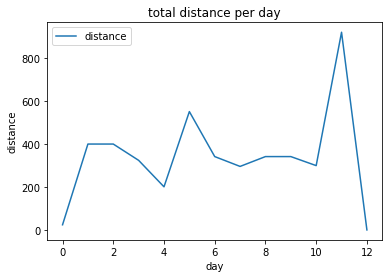

In [9]:
#showing our plot
dff.plot()
plt.xlabel("day")
plt.ylabel("distance")
plt.xaxis = np.arange(0, 12, 2)
plt.title("total distance per day")

## Stationary check:

##### one approach is to use p_value(the probability that the results from your sample data occurred by chance). if p_value goes upto 0.05, proofs that our data is non-stationary.

In [10]:
# use adfuller func from statsmodels.tsa.stattools to compute the p_value
adf_test = adfuller(dff.distance)
print(f'p-value: {adf_test[1]}')

p-value: 7.344220151440718e-07


##### our p-value proofs that the data is not Stationary. 
##### we found out that the d value(differencing) in ARIMA_order must be at least 1. because the d shows us how many differencing we need(0 or 1 or 2).
##### let's check if we need 2steps differencing or not.

In [11]:
dif1 = dff.distance.diff().fillna(dff.distance)
dif2 = adfuller(dif1)
print(f'p-value: {dif2[1]}')

p-value: 0.005189807201270715


##### with 1step differencing,  p-value goes down to 0.05. so we need no more differencing and the d value in ARIMA_order is 1.

## ACF plot

##### Looking at the number of lags crossing the threshold in ACF(except the first lag), we can determine how much of the past would be significant enough to consider for the future and determine the 'q', so: q=0

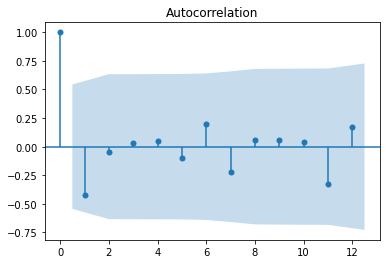

In [12]:
acf_plot = plot_acf(dff.distance)

## PACF

#####  we determine 'p' based on the number of most significant lag crossing the threshold in  the partial autocorrelation plot, except the first lag, cause it is the correlation of the first data with itself, so: p=0


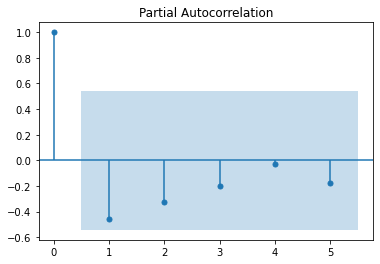

In [13]:
pacf_plot = plot_pacf(dff.distance , lags=int(len(dff.distance)/2 -1))

## ARIMA model

#### based on ACF/PACF/stationary check, our order is (p,d,q)=(0,1,0)

In [14]:
model = ARIMA(dff.distance, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.distance   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -87.713
Method:                           css   S.D. of innovations            361.578
Date:                Sun, 13 Nov 2022   AIC                            179.426
Time:                        20:55:06   BIC                            180.396
Sample:                             1   HQIC                           179.067
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9929    104.379     -0.019      0.985    -206.571     202.585


e:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


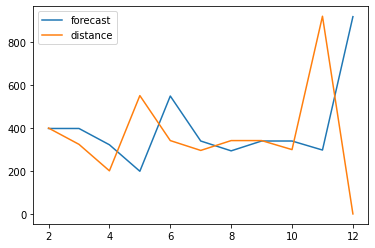

In [15]:
model_fit.plot_predict(dynamic=False)
plt.show()

## now it's time to insert some random parameter into ARIMA model:
### model_fit1 = (0,1,1)

In [16]:
model = ARIMA(dff.distance, order=(0,1,1))
model_fit1 = model.fit()
print(model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.distance   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -83.256
Method:                       css-mle   S.D. of innovations            224.114
Date:                Sun, 13 Nov 2022   AIC                            172.511
Time:                        20:55:06   BIC                            173.966
Sample:                             1   HQIC                           171.973
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.7453     16.612      0.707      0.480     -20.815      44.305
ma.L1.D.distance    -1.0000      0.213     -4.700      0.000      -1.417      -0.583
                            

e:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


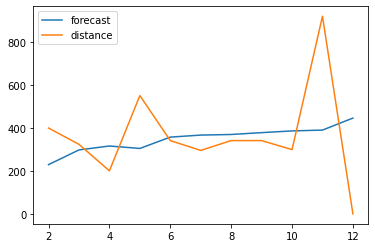

In [17]:
model_fit1.plot_predict(dynamic=False)
plt.show()

### model_fit2 = (2,1,0)

In [18]:
model = ARIMA(dff.distance, order=(2,1,0))
model_fit2 = model.fit()
print(model_fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.distance   No. Observations:                   12
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -82.406
Method:                       css-mle   S.D. of innovations            213.524
Date:                Sun, 13 Nov 2022   AIC                            172.813
Time:                        20:55:06   BIC                            174.752
Sample:                             1   HQIC                           172.095
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.4923     22.920      0.850      0.395     -25.430      64.415
ar.L1.D.distance    -1.2943      0.278     -4.663      0.000      -1.838      -0.750
ar.L2.D.distance    -0.6397 

e:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


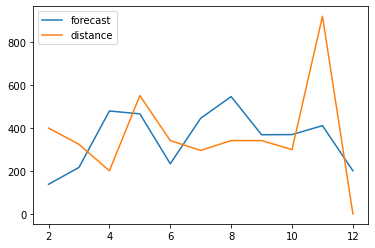

In [19]:
model_fit2.plot_predict(dynamic=False)
plt.show()

### model_fit3 = (0,1,3)

In [20]:
model = ARIMA(dff.distance, order=(0,1,3))
model_fit3 = model.fit()
print(model_fit3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.distance   No. Observations:                   12
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 -81.392
Method:                       css-mle   S.D. of innovations            159.004
Date:                Sun, 13 Nov 2022   AIC                            172.783
Time:                        20:55:07   BIC                            175.208
Sample:                             1   HQIC                           171.886
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.4616      9.204      2.440      0.015       4.421      40.502
ma.L1.D.distance    -2.0314      0.249     -8.164      0.000      -2.519      -1.544
ma.L2.D.distance     2.0314 

e:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
e:\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hes

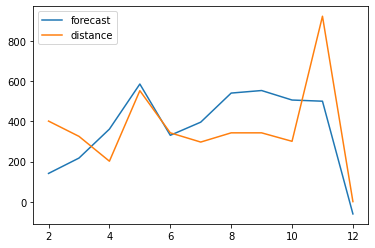

In [21]:
model_fit3.plot_predict(dynamic=False)
plt.show()

## Conclusion

#### as you can see none of them is really accurate except the first one.
#### finding the best fit order for(p,d,q) is really important, so we use the model_fit order(0,1,0) and put the order into predict() and forecast() function for as many days as we want. for example 4  days.

In [22]:
#prediction for 4 days later
model_fit.predict()
print(model_fit.forecast(4))

(array([-0.7236475, -2.716595 , -4.7095425, -6.70249  ]), array([361.57775697, 511.34816776, 626.27104596, 723.15551395]), array([[ -709.40302878,   707.95573378],
       [-1004.94058738,   999.50739738],
       [-1232.17823715,  1222.75915215],
       [-1424.06125256,  1410.65627256]]))
